In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## Data

In [3]:
x = [1,1,1,1,1,4,8,4,1,1,1,1,1]
y = [1,1,1,1,1,4,8,4,1,1,1,1,1]
x = x/np.sum(x)          # p(x)
y = y/np.sum(y)          # p(y)
xy = y[None].T @ x[None] # p(x,y)

xy = xy/np.sum(xy)

xy

array([[0.00147929, 0.00147929, 0.00147929, 0.00147929, 0.00147929,
        0.00591716, 0.01183432, 0.00591716, 0.00147929, 0.00147929,
        0.00147929, 0.00147929, 0.00147929],
       [0.00147929, 0.00147929, 0.00147929, 0.00147929, 0.00147929,
        0.00591716, 0.01183432, 0.00591716, 0.00147929, 0.00147929,
        0.00147929, 0.00147929, 0.00147929],
       [0.00147929, 0.00147929, 0.00147929, 0.00147929, 0.00147929,
        0.00591716, 0.01183432, 0.00591716, 0.00147929, 0.00147929,
        0.00147929, 0.00147929, 0.00147929],
       [0.00147929, 0.00147929, 0.00147929, 0.00147929, 0.00147929,
        0.00591716, 0.01183432, 0.00591716, 0.00147929, 0.00147929,
        0.00147929, 0.00147929, 0.00147929],
       [0.00147929, 0.00147929, 0.00147929, 0.00147929, 0.00147929,
        0.00591716, 0.01183432, 0.00591716, 0.00147929, 0.00147929,
        0.00147929, 0.00147929, 0.00147929],
       [0.00591716, 0.00591716, 0.00591716, 0.00591716, 0.00591716,
        0.02366864, 0.04733

## p(x,y)/p(x)p(y)

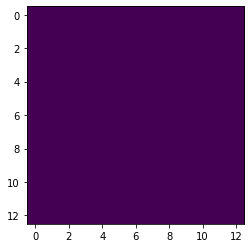

In [4]:
x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]
plt.imshow(xy/xyind)

## p(x,y)

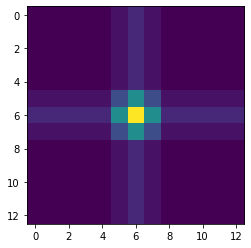

In [5]:
plt.imshow(xy)

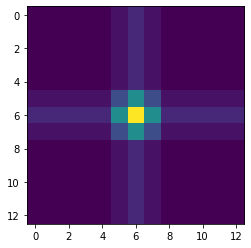

In [6]:
plt.imshow(xyind)

## Experiments

In [25]:
def run_expr_joint(n_batch, iters):
    '''
    model pxy directly
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data

    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi = F[samples[i,0],samples[i,1]]/torch.sum(F[:,:])
            loss = loss + torch.log(lossi) 
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 1000 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"contrived_independent_training_results/Mbar_joint_{n_batch}_{iteration}.png")

    np.save(f'contrived_independent_training_results/Mbar_joint_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'contrived_independent_training_results/M_joint_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'contrived_independent_training_results/training_loss_joint_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 3/1999 [00:00<01:23, 23.87it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


 50%|█████     | 1002/1999 [00:39<00:43, 22.93it/s]

tensor(1.1456, grad_fn=<VarBackward0>)


100%|██████████| 1999/1999 [01:17<00:00, 25.85it/s]


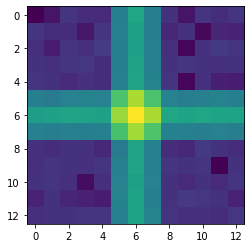

In [26]:
# model pxy directly
M, Mbar, history = run_expr_joint(n_batch=500, iters=2000)

In [28]:
Mbar_joint = torch.from_numpy(np.load(f'contrived_independent_training_results/Mbar_joint_{500}_{1999}.npy'))
M_joint = torch.from_numpy(np.load(f'contrived_independent_training_results/M_joint_{500}_{1999}.npy'))

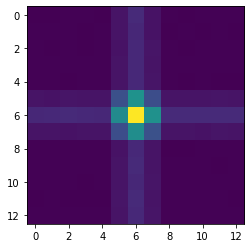

In [29]:
plt.imshow(torch.exp(Mbar_joint))

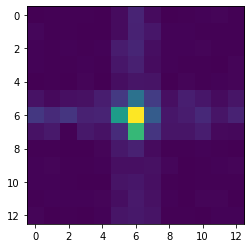

In [30]:
plt.imshow(torch.exp(M_joint))

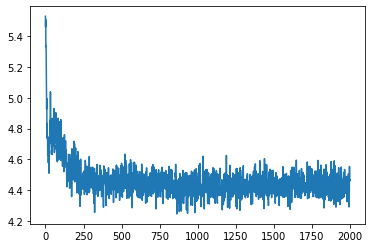

In [31]:
plt.plot(history['loss'])

In [34]:
# Compare Fbar=exp(Mbar) with xy
F_joint = torch.exp(Mbar_joint)
F_joint_normalized = F_joint/torch.sum(F_joint)
log_F_joint_normalized = torch.log(F_joint_normalized)

F.kl_div(log_F_joint_normalized, torch.from_numpy(xy))

/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(5.8801e-06, dtype=torch.float64)

In [35]:
def run_expr_pseudo(n_batch, iters):
    '''
    model x|y and y|x
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data

    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], range(xy.shape[1])])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[range(xy.shape[0]), samples[i,1]])

            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 1000 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"contrived_independent_training_results/Mbar_pseudo_{n_batch}_{iteration}.png")

    np.save(f'contrived_independent_training_results/Mbar_pseudo_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'contrived_independent_training_results/M_pseudo_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'contrived_independent_training_results/training_loss_pseudo_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 2/1999 [00:00<02:39, 12.53it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


 50%|█████     | 1000/1999 [01:23<01:29, 11.21it/s]

tensor(1.1391, grad_fn=<VarBackward0>)


100%|██████████| 1999/1999 [02:45<00:00, 12.07it/s]


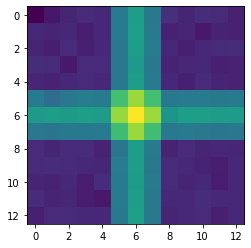

In [36]:
# Correct
# model full px|y and py|x directly
M, Mbar, history = run_expr_pseudo(n_batch=500, iters=2000)

In [38]:
Mbar_pseudo = torch.from_numpy(np.load(f'contrived_independent_training_results/Mbar_pseudo_{500}_{1999}.npy'))
M_pseudo = torch.from_numpy(np.load(f'contrived_independent_training_results/M_pseudo_{500}_{1999}.npy'))

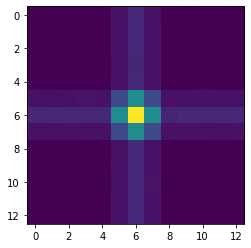

In [39]:
plt.imshow(torch.exp(Mbar_pseudo))

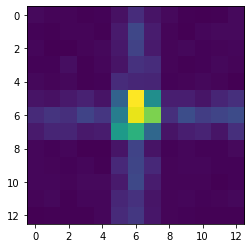

In [40]:
plt.imshow(torch.exp(M_pseudo))

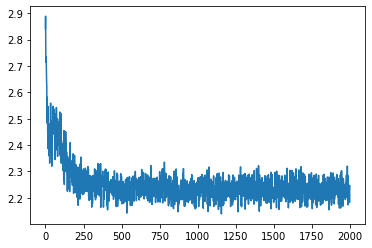

In [37]:
plt.plot(history['loss'])

In [41]:
# Compare Mbar with xy
F_pseudo = torch.exp(Mbar_pseudo)
F_pseudo_normalized = F_pseudo/torch.sum(F_pseudo)
log_F_pseudo_normalized = torch.log(F_pseudo_normalized)

F.kl_div(log_F_pseudo_normalized, torch.from_numpy(xy))

tensor(3.9604e-06, dtype=torch.float64)

In [7]:
def run_expr_infoNCE(n_batch, iters):
    '''
    infoNCE
    '''
    torch.manual_seed(42)
    
    M = torch.randn(xy.shape, requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data

    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
#         import pdb; pdb.set_trace()
        
        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], samples[:,1]])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[:,0], samples[i,1]])
            
            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 1000 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"contrived_independent_training_results/Mbar_infoNCE_{n_batch}_{iteration}.png")

    np.save(f'contrived_independent_training_results/Mbar_infoNCE_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'contrived_independent_training_results/M_infoNCE_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'contrived_independent_training_results/training_loss_infoNCE_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 1/2499 [00:00<05:51,  7.10it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


 40%|████      | 1001/2499 [01:24<02:17, 10.90it/s]

tensor(0.0918, grad_fn=<VarBackward0>)


 80%|████████  | 2001/2499 [02:47<00:43, 11.36it/s]

tensor(0.0857, grad_fn=<VarBackward0>)


100%|██████████| 2499/2499 [03:29<00:00, 11.95it/s]


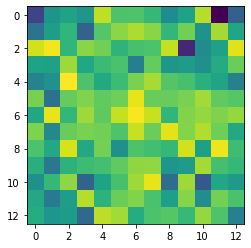

In [8]:
# Correct
# info NCE both directions
M, Mbar, history = run_expr_infoNCE(n_batch=500, iters=2500)

In [14]:
Mbar_infoNCE = torch.from_numpy(np.load(f'contrived_independent_training_results/Mbar_infoNCE_{500}_{2499}.npy'))
M_infoNCE = torch.from_numpy(np.load(f'contrived_independent_training_results/M_infoNCE_{500}_{2499}.npy'))

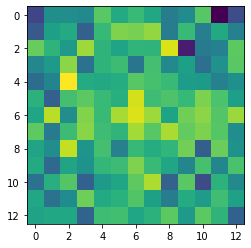

In [15]:
plt.imshow(torch.exp(Mbar_infoNCE))

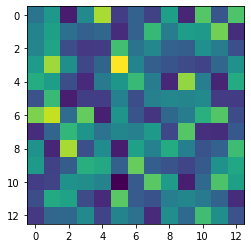

In [16]:
plt.imshow(torch.exp(M_infoNCE))

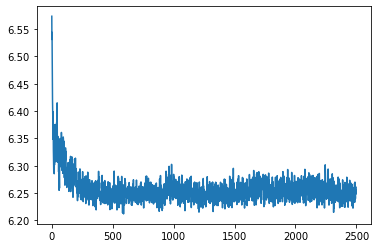

In [17]:
plt.plot(history['loss'])

In [18]:
# Compare Mbar with xy
F_infoNCE = torch.exp(Mbar_infoNCE)
F_infoNCE_normalized = F_infoNCE/torch.sum(F_infoNCE)
log_F_infoNCE_normalized = torch.log(F_infoNCE_normalized)

F.kl_div(log_F_infoNCE_normalized, torch.from_numpy(xy))

tensor(0.0043, dtype=torch.float64)